# Try with DeepWalk Algorithm

In [5]:
import numpy as np
import networkx as nx
import threading
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from concurrent.futures import ThreadPoolExecutor

Create a customed Graph

In [6]:
class Graph:
    def __init__(self, graph_dict = None, directed = False):
        self.graph_dict = graph_dict or {}
        self.directed = directed
        self.lock = threading.Lock()

        if not directed:
            self.make_undirected()

    def get_vertices(self):
        return list(self.graph_dict.keys())

    def make_adjacency_matrix(self):
        vertices = list(self.graph_dict.keys())
        shape_matrix = len(vertices)
        adj_matrix = np.zeros((shape_matrix, shape_matrix))

        for i in range(shape_matrix):
            for j in range(shape_matrix):
                if vertices[j] in self.graph_dict[vertices[i]]:
                    adj_matrix[i][j] = 1

        return adj_matrix


    def add_vertices(self, vertex):
        if vertex not in self.graph_dict:
            self.graph_dict[vertex] = []

    def add_edges(self, vertex1, vertex2):
        self.add_vertices(vertex1)
        self.add_vertices(vertex2)
        self.graph_dict[vertex1].append(vertex2)

        if not self.directed:
            self.graph_dict[vertex2].append(vertex1)

    def make_undirected(self):
        for vertex in self.graph_dict:
            for neighbor in self.graph_dict[vertex]:
                if vertex not in self.graph_dict[neighbor]:
                    self.graph_dict[neighbor].append(vertex)

    def to_networkx(self):
        if self.directed:
            G_nx = nx.DiGraph()
        else:
            G_nx = nx.Graph()

        for vertex, neighbors in self.graph_dict.items():
            G_nx.add_node(vertex)
            for neighbor in neighbors:
                G_nx.add_edge(vertex, neighbor)

        return G_nx

    def __str__(self):
        return str(self.graph_dict)



In [7]:
G = Graph()
G.add_vertices('A')
G.add_vertices('B')
G.add_vertices('C')
G.add_vertices('D')
G.add_vertices('E')
G.add_vertices('F')
G.add_vertices('G')
G.add_vertices('H')
G.add_edges('A', 'B')
G.add_edges('A', 'C')
G.add_edges('B', 'D')
G.add_edges('C', 'E')
G.add_edges('D', 'E')
G.add_edges('D', 'F')
G.add_edges('E', 'F')
G.add_edges('E', 'G')
G.add_edges('F', 'H')
G.add_edges('G', 'H')
G.add_edges('H', 'A')
G.add_edges('H', 'B')
G.add_edges('H', 'C')


print(G.graph_dict)

{'A': ['B', 'C', 'H'], 'B': ['A', 'D', 'H'], 'C': ['A', 'E', 'H'], 'D': ['B', 'E', 'F'], 'E': ['C', 'D', 'F', 'G'], 'F': ['D', 'E', 'H'], 'G': ['E', 'H'], 'H': ['F', 'G', 'A', 'B', 'C']}


In [8]:
adj_matrix = G.make_adjacency_matrix()
print(adj_matrix)

[[0. 1. 1. 0. 0. 0. 0. 1.]
 [1. 0. 0. 1. 0. 0. 0. 1.]
 [1. 0. 0. 0. 1. 0. 0. 1.]
 [0. 1. 0. 0. 1. 1. 0. 0.]
 [0. 0. 1. 1. 0. 1. 1. 0.]
 [0. 0. 0. 1. 1. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 1.]
 [1. 1. 1. 0. 0. 1. 1. 0.]]


In [10]:
g_nx = G.to_networkx()
print(g_nx.nodes)
print(g_nx.edges)

['A', 'B', 'C', 'H', 'D', 'E', 'F', 'G']
[('A', 'B'), ('A', 'C'), ('A', 'H'), ('B', 'D'), ('B', 'H'), ('C', 'E'), ('C', 'H'), ('H', 'F'), ('H', 'G'), ('D', 'E'), ('D', 'F'), ('E', 'F'), ('E', 'G')]


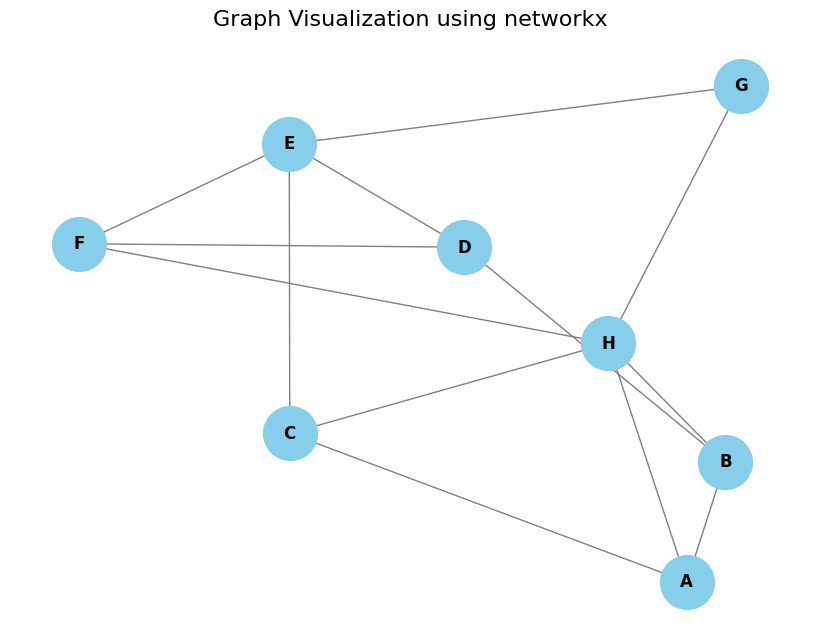

In [11]:
# Visualize the graph using networkx
plt.figure(figsize=(8, 6))
nx.draw(g_nx, with_labels=True, node_color='skyblue',
        node_size=1500, edge_color='gray', font_size=12, font_weight='bold')
plt.title("Graph Visualization using networkx", fontsize=16)
plt.show()

## Random Walk Algorithm

The random walk in DeepWalk generates sequences of nodes (analogous to sentences in NLP). These sequences capture the graph's local and global structure, which are then used for training a Skip-gram model to generate embeddings. The sequences of nodes are chosen randomly from the neighbor 
of the current node and repeat until reaches the specified length 

### Steps in Random Walk for DeepWalk

1. **Graph Initialization**  
   Input is an undirected graph $(G = (V, E))$, where $V$ represents nodes, and $E$ represents edges.

2. **Random Walk Parameters**  
   - **Walk length  $l$**: The number of steps in each random walk.
   - **Number of walks per node $k$**: How many walks to start from each node.
   - **Transition probabilities**: Uniform for a basic random walk, meaning all neighbors have an equal chance of being chosen.

3. **Generate Random Walks**  
   For each node $v_i \in V$:
   - Start a random walk at $v_i$.
   - At each step, choose $v_k$ to a randomly chosen neighbor of the current node, for which $k \in \mathcal{N}(v_i)$ and the set $\mathcal{N}(v_i)$ is the neighborhood of the vertex $v_i$.
   - Continue until the walk reaches the specified length $l$.
   
   This generates a corpus of random walks (node sequences).

4. **Train Skip-gram Model**  
   Treat the random walks as a "text corpus" and train a Skip-gram model (e.g., from Word2Vec) to learn node embeddings.

---

In [17]:
# The algorithm of the Random Algorithm 
def random_walk(graph, start_vertex, num_steps):
    """
    Performs a random walk on a graph starting from a specified vertex.

    Parameters
    ----------
    graph: Graph object
        The graph containing nodes (vertices) and edges.
    start_vertex: Any
        The starting node for the random walk.
    num_steps: int
        The number of steps the random walk should take.

    Returns
    -------
    traverse_path: list
        A list of nodes visited during the random walk.

    Raises
    ------
    ValueError
        If the start_vertex is not a valid node in the graph.
    """
    if start_vertex not in graph.graph_dict:
        return ValueError("Start vertex not in graph")

    current_vertex = start_vertex
    traverse_path = [current_vertex]

    for _ in range(num_steps):
        neighbors = graph.graph_dict[current_vertex]

        if not neighbors:
            break

        next_step = np.random.choice(neighbors)    
        traverse_path.append(next_step)
        current_vertex = next_step

    return traverse_path


# Conducting the algorithm with multi-threading to improve the performance of the model
def random_walk_multi(graph, start_vertices, num_steps, num_threads = 4):
    results = {}

    def worker(start_vertex):
        path = random_walk(graph, start_vertex, num_steps)
        with graph.lock:
            results[start_vertex] = path

    with ThreadPoolExecutor(max_workers = num_threads) as executor:
        executor.map(worker, start_vertices)

    return results


start_vertices = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H']
num_steps = 4
num_threads = 4

result_paths = random_walk_multi(G, start_vertices, num_steps, num_threads)
print(result_paths)

{'A': ['A', np.str_('B'), np.str_('A'), np.str_('B'), np.str_('D')], 'B': ['B', np.str_('A'), np.str_('C'), np.str_('E'), np.str_('C')], 'C': ['C', np.str_('H'), np.str_('C'), np.str_('E'), np.str_('G')], 'D': ['D', np.str_('E'), np.str_('D'), np.str_('F'), np.str_('E')], 'E': ['E', np.str_('C'), np.str_('E'), np.str_('F'), np.str_('H')], 'F': ['F', np.str_('H'), np.str_('A'), np.str_('C'), np.str_('A')], 'G': ['G', np.str_('E'), np.str_('G'), np.str_('E'), np.str_('D')], 'H': ['H', np.str_('B'), np.str_('H'), np.str_('A'), np.str_('C')]}


## Implementing the DeepWalk algorithm

These random walks sequences can be thought as the basic phrases or sentences of the graph. We can take the direct analogy to the concept of Word2Vec, which estimate the likelihood of observing the vertex $v_i$ given the the neighboring vertex $v_k$. However, the goal is to learn the latent representation $\Phi \in \mathbb{R}^{|V| \times d}$. The mapping $\Phi : v_i \in \mathbb{R} \rightarrow \mathbb{R}^{d}$ is the social representation of the vertex $v_i$.

The problem then to estimate the likelihood:

$$Pr(v_i | (\Phi(v_1), \Phi(v_2). \dots, \Phi(v_{i - 1}))$$

However, as the length of walk increases, computing the equation above is unfeasible. Hence, we have:
- Use 1 word to predict the context
- The context are the words in the left or in the right of the targeted word
- Removes the ordering constraint

Which is equivalent to the optimization problem below 
$$\underset{\Phi}{\text{minimize}} \quad - \log \Pr\left(\{v_{i-w}, \cdots, v_{i-1}, v_{i+1}, \cdots, v_{i+w}\} \mid \Phi(v_i)\right)$$

Solving the problem above captures the shared similarities in local graph structure between vertices. It can be paraphrased as the sum of the probabilities $P(v_k | v_i)$, speeding up the training time. The process above is called Skip Gram Algorithm, which is used a lot in word2vec algorithm in NLP field

Solving this optimization captures the shared similarities in the local graph structure between vertices. It can be viewed as the sum of probabilities 
𝑃
(
𝑣
𝑘
∣
𝑣
𝑖
)
P(v 
k
​
 ∣v 
i
​
 ), which helps accelerate training. This process is known as the Skip Gram Algorithm, a key component of the Word2Vec algorithm used in Natural Language Processing (NLP)

In [18]:
class DeepWalk(nn.Module):
    def __init__(self, num_nodes, embedding_dim):
        super(DeepWalk, self).__init__()
        self.embeddings = nn.Embedding(num_nodes, embedding_dim)
        # self.output_layer = nn.Linear(embedding_dim, num_nodes, bias = False)

    def forward(self, center, context):
        # return self.output_layer(self.embeddings(input_walks))

        center_embed = self.embeddings(center)
        context_embed = self.embeddings(context)

        # Applying log-sum-exp trick to solve the overflow problem
        result = torch.matmul(center_embed, context_embed.T) # (B, 1)
        all_logits = torch.matmul(center_embed, self.embeddings.weight.T) # (B, Vocab_size)

        max_logits, _ = torch.max(all_logits, dim = 1, keepdim = True)
        log_sum_exp = max_logits + torch.log(torch.sum(torch.exp(all_logits - max_logits), dim=1, keepdim=True))

        log_prob = result - log_sum_exp

        return log_prob